# Flash Point: Fire Rescue

## Instalación e importación de librerías

In [153]:
# Descargar e instalar mesa, seaborn y plotly

%pip install mesa==2.3.1 seaborn plotly --quiet

Note: you may need to restart the kernel to use updated packages.


In [154]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que el tablero está representado por un grafo, importamos la clase 'NetworkGrid'.
from mesa.space import NetworkGrid

# Con 'SimultaneousActivation' podemos activar todos los agentes al mismo tiempo.
from mesa.time import SimultaneousActivation

# Importamos 'RandomActivation' para activar los agentes en un orden aleatorio.
from mesa.time import RandomActivation

# Importamos 'RandomActivationByType' para activar los agentes de un tipo específico en un orden aleatorio.
from mesa.time import RandomActivationByType

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# BATCH_RUNNER
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Importamos el paquete seaborn para mejorar la visualización de los datos.
import seaborn as sns

# Importamos el paquete plotly para crear gráficos interactivos.
import plotly.graph_objects as go

# Importamos el paquete networkx para crear grafos.
import networkx as nx

# Importamos el paquete json para leer archivos de configuración.
import json

## Inicialización del proyecto

### Leer archivo de configuración

In [155]:
def read_board_config():
    """
    Leer el archivo de configuración del tablero y devolver un diccionario con la configuración
    """

    # Abrir el archivo de configuración
    file = open("board-config.txt", "r")

    # Obtener la información del tablero
    config = file.readlines()

    # Cerrar el archivo
    file.close()

    # Crear un diccionario para almacenar la configuración del tablero
    board_config = {}

    # Configuración del tablero
    board_config['board'] = [x.replace("\n", "").split() for x in config[:6]]

    # Puntos de interés
    board_config['points_of_interest'] = [x.replace("\n", "").split() for x in config[6:9]]

    # Indicadores de fuego
    board_config['fire_indicators'] = [x.replace("\n", "").split() for x in config[9:19]]

    # Puertas
    board_config['doors'] = [x.replace("\n", "").split() for x in config[19:27]]

    # Puntos de entrada
    board_config['entry_points'] = [x.replace("\n", "").split() for x in config[27:31]]

    return board_config

In [156]:
board_config = read_board_config()

board_config

{'board': [['1100', '1000', '1001', '1100', '1001', '1100', '1000', '1001'],
  ['0100', '0000', '0011', '0100', '0011', '0110', '0010', '0011'],
  ['0100', '0001', '1100', '1000', '1000', '1001', '1100', '1001'],
  ['0100', '0011', '0110', '0010', '0010', '0011', '0110', '0011'],
  ['1100', '1000', '1000', '1000', '1001', '1100', '1001', '1101'],
  ['0110', '0010', '0010', '0010', '0011', '0110', '0011', '0111']],
 'points_of_interest': [['2', '4', 'v'], ['5', '1', 'f'], ['5', '8', 'v']],
 'fire_indicators': [['2', '2'],
  ['2', '3'],
  ['3', '2'],
  ['3', '3'],
  ['3', '4'],
  ['3', '5'],
  ['4', '4'],
  ['5', '6'],
  ['5', '7'],
  ['6', '6']],
 'doors': [['1', '3', '1', '4'],
  ['2', '5', '2', '6'],
  ['2', '8', '3', '8'],
  ['3', '2', '3', '3'],
  ['4', '4', '5', '4'],
  ['4', '6', '4', '7'],
  ['6', '5', '6', '6'],
  ['6', '7', '6', '8']],
 'entry_points': [['1', '6'], ['3', '1'], ['4', '8'], ['6', '3']]}

### Funciones para crear el grafo del tablero

In [157]:
def read_board(board_config):
    """
    Inicializa el tablero como un grafo usando NetworkX.
    """

    # Crear un grafo vacío
    G = nx.Graph()

    # Expandir el tablero con un anillo exterior
    rows = len(board_config['board'])
    cols = len(board_config['board'][0])

    expanded_board = [['x' for _ in range(cols + 2)] for _ in range(rows + 2)]

    # Copiar la información del tablero original al centro del tablero expandido
    for i in range(rows):
        for j in range(cols):
            expanded_board[i + 1][j + 1] = board_config['board'][i][j]

    # Ajustar las coordenadas de las puertas
    doors = {}
    for door in board_config['doors']:
        doors[(int(door[0]), int(door[1]))] = (int(door[2]), int(door[3]))
        doors[(int(door[2]), int(door[3]))] = (int(door[0]), int(door[1]))  # Puerta bidireccional

    # Agregar nodos para cada celda del tablero expandido
    for i in range(rows + 2):
        for j in range(cols + 2):
            if i == 0 or j == 0 or i == rows + 1 or j == cols + 1:
                # Nodo en el anillo exterior
                G.add_node((i, j), fire=0, POI=None, is_entry_point=False, type='exterior', agent=None)
            else:
                # Nodo dentro del tablero original
                G.add_node((i, j), fire=0, POI=None, is_entry_point=False, type='interior', agent=None)

    # Crear las conexiones del tablero expandido
    for i in range(rows + 2):
        for j in range(cols + 2):
            current_cell = expanded_board[i][j] if 0 < i < rows + 1 and 0 < j < cols + 1 else None

            # Procesar las conexiones para cada dirección
            # Arriba
            if i > 0:
                neighbor_cell = expanded_board[i - 1][j] if i - 1 > 0 else None
                if (i, j) in doors and doors[(i, j)] == (i - 1, j):
                    add_door(G, (i, j), (i - 1, j))  # Puerta
                elif current_cell and neighbor_cell:
                    if current_cell[0] == '1' or neighbor_cell[2] == '1':
                        add_wall(G, (i, j), (i - 1, j))  # Muro
                    else:
                        add_path(G, (i, j), (i - 1, j))  # Camino
                elif not G.has_edge((i, j), (i - 1, j)):
                    add_wall(G, (i, j), (i - 1, j))  # Muro por defecto

            # Izquierda
            if j > 0:
                neighbor_cell = expanded_board[i][j - 1] if j - 1 > 0 else None
                if (i, j) in doors and doors[(i, j)] == (i, j - 1):
                    add_door(G, (i, j), (i, j - 1))
                elif current_cell and neighbor_cell:
                    if current_cell[1] == '1' or neighbor_cell[3] == '1':
                        add_wall(G, (i, j), (i, j - 1))  # Muro
                    else:
                        add_path(G, (i, j), (i, j - 1))  # Camino
                elif not G.has_edge((i, j), (i, j - 1)):
                    add_wall(G, (i, j), (i, j - 1))  # Muro por defecto

            # Abajo
            if i < rows + 1:
                neighbor_cell = expanded_board[i + 1][j] if i + 1 <= rows else None
                if (i, j) in doors and doors[(i, j)] == (i + 1, j):
                    add_door(G, (i, j), (i + 1, j))  # Puerta
                elif current_cell and neighbor_cell:
                    if current_cell[2] == '1' or neighbor_cell[0] == '1':
                        add_wall(G, (i, j), (i + 1, j))  # Muro
                    else:
                        add_path(G, (i, j), (i + 1, j))  # Camino
                elif not G.has_edge((i, j), (i + 1, j)):
                    add_wall(G, (i, j), (i + 1, j))  # Muro por defecto

            # Derecha
            if j < cols + 1:
                neighbor_cell = expanded_board[i][j + 1] if j + 1 <= cols else None
                if (i, j) in doors and doors[(i, j)] == (i, j + 1):
                    add_door(G, (i, j), (i, j + 1))  # Puerta
                elif current_cell and neighbor_cell:
                    if current_cell[3] == '1' or neighbor_cell[1] == '1':
                        add_wall(G, (i, j), (i, j + 1))  # Muro
                    else:
                        add_path(G, (i, j), (i, j + 1))  # Camino
                elif not G.has_edge((i, j), (i, j + 1)):
                    add_wall(G, (i, j), (i, j + 1))  # Muro por defecto
    
    # Conectar nodos exteriores entre sí
    for node in G.nodes:
        if G.nodes[node]['type'] == 'exterior':
            for neighbor in G.adj[node]:
                # Verificar si ambos nodos son exteriores
                if G.nodes[neighbor]['type'] == 'exterior':
                    # Asegurarse de que la conexión sea un camino
                    if not G.has_edge(node, neighbor):
                        G.add_edge(node, neighbor, weight=1, type='path')
                    elif G[node][neighbor].get('type') != 'path':
                        # Sobreescribir cualquier conexión incorrecta con un camino
                        G[node][neighbor]['type'] = 'path'
                        G[node][neighbor]['weight'] = 1


    # Configurar puntos de interés y fuego inicial
    for poi in board_config['points_of_interest']:
        add_POI(G, (int(poi[0]), int(poi[1])), poi[2] == 'v')
    for fire in board_config['fire_indicators']:
        add_fire(G, (int(fire[0]), int(fire[1])))

    # Conectar puntos de entrada a nodos externos
    for entry_point in board_config['entry_points']:
        entry_x, entry_y = int(entry_point[0]), int(entry_point[1])
        G.nodes[(entry_x, entry_y)]['isEntryPoint'] = True

        # Conectar al nodo externo más cercano
        neighbors = [
            (entry_x - 1, entry_y),  # Arriba
            (entry_x + 1, entry_y),  # Abajo
            (entry_x, entry_y - 1),  # Izquierda
            (entry_x, entry_y + 1)   # Derecha
        ]

        for neighbor in neighbors:
            if neighbor in G.nodes and G.nodes[neighbor]['type'] == 'exterior':
                # Asegurarse de que sea un camino, no un muro
                if G.has_edge((entry_x, entry_y), neighbor):
                    G[(entry_x, entry_y)][neighbor]['type'] = 'path'
                    G[(entry_x, entry_y)][neighbor]['weight'] = 1
                else:
                    # Crear una nueva conexión como un camino
                    G.add_edge((entry_x, entry_y), neighbor, type='path', weight=1)


    return G

def validate_graph(G):
    """
    Validar y actualizar los pesos de las aristas en el grafo en función del estado actual (fuego, humo, puertas).
    """

    for edge in G.edges(data=True):
        node1, node2, edge_data = edge

        # Determinar el estado de los nodos conectados
        fire_status1 = G.nodes[node1].get('fire', 0)  # Nodo 1: 0 (nada), 1 (humo), 2 (fuego)
        fire_status2 = G.nodes[node2].get('fire', 0)  # Nodo 2: 0 (nada), 1 (humo), 2 (fuego)
        edge_type = edge_data.get('type', 'path')  # Por defecto, consideramos 'path'

        # Determinar el peso en función del peor caso (fuego > humo > nada)
        fire_status = max(fire_status1, fire_status2)

        # Ajustar el peso según el estado del nodo y el tipo de conexión
        if fire_status == 2:  # Fuego
            if edge_type == 'path':
                G[node1][node2]['weight'] = 3
            elif edge_type == 'wall':
                G[node1][node2]['weight'] = 7
            elif edge_type == 'door':
                if edge_data.get('is_open', False):
                    G[node1][node2]['weight'] = 3
                else:
                    G[node1][node2]['weight'] = 4
        elif fire_status == 1:  # Humo
            if edge_type == 'path':
                G[node1][node2]['weight'] = 2
            elif edge_type == 'wall':
                G[node1][node2]['weight'] = 6
            elif edge_type == 'door':
                if edge_data.get('is_open', False):
                    G[node1][node2]['weight'] = 2
                else:
                    G[node1][node2]['weight'] = 3
        else:  # Sin fuego ni humo
            if edge_type == 'path':
                G[node1][node2]['weight'] = 1
            elif edge_type == 'wall':
                G[node1][node2]['weight'] = 5
            elif edge_type == 'door':
                if edge_data.get('is_open', False):
                    G[node1][node2]['weight'] = 1
                else:
                    G[node1][node2]['weight'] = 2

def initialize_board(board_config):
    """
    Inicializar el tablero como un grafo con la configuración del archivo de configuración.
    """

    G = read_board(board_config)

    # Validar y actualizar los pesos de las aristas
    validate_graph(G)

    return G

    """
    Inicializar el tablero como un grafo con la configuración del archivo de configuración.
    """

    G = read_board(board_config)

    # Validar y actualizar los pesos de las aristas
    validate_graph(G)

    return G


### Funciones para visualización

In [158]:
def plot_graph(G, title='Flash Point: Fire Rescue'):
    """
    Graficar el grafo con Plotly, mostrando las conexiones de los nodos al hacer hover.
    """

    # Definir las posiciones de los nodos como una cuadrícula
    pos = {node: (node[1], -node[0]) for node in G.nodes()}  # El eje y se invierte para que la visualización sea de arriba a abajo

    # Crear trazas para las aristas con colores según su tipo y mostrar peso y tipo
    edge_x = []
    edge_y = []
    edge_colors = []
    edge_annotations = []

    # Definir los colores para cada tipo de arista
    edge_type_colors = {
        'wall': 'red',
        'path': 'green',
        'door': 'blue',
        'unknown': 'gray'  # Color por defecto para tipos no definidos
    }

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)  # Para separar las líneas de las aristas
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

        # Asignar color según el tipo de la arista
        edge_type = edge[2].get('type', 'unknown')  # 'unknown' si no tiene tipo
        edge_colors.append(edge_type_colors.get(edge_type, 'gray'))  # Usar color definido o 'gray'

        # Guardar anotaciones para peso, tipo, y estado de apertura (si es una puerta)
        weight = edge[2].get('weight', '?')
        is_open = edge[2].get('is_open', None)  # Obtener el estado de apertura (None si no aplica)
        if edge_type == 'door':  # Solo agregar estado de apertura para puertas
            door_state = 'Abierta' if is_open else 'Cerrada'
            annotation_text = f'{weight}<br>{edge_type}<br>{door_state}'
        else:
            annotation_text = f'{weight}<br>{edge_type}'

        edge_annotations.append(
            dict(
                x=(x0 + x1) / 2,
                y=(y0 + y1) / 2,
                text=annotation_text,  # Mostrar peso, tipo y estado de apertura
                showarrow=False,
                font=dict(size=10, color='black')
            )
        )

    # Crear trazas para las aristas coloreadas
    edge_traces = []
    for idx in range(len(edge_colors)):
        edge_traces.append(
            go.Scatter(
                x=[edge_x[idx * 3], edge_x[idx * 3 + 1], None],
                y=[edge_y[idx * 3], edge_y[idx * 3 + 1], None],
                line=dict(width=2, color=edge_colors[idx]),
                hoverinfo='none',
                mode='lines'
            )
        )

    # Crear trazas para los nodos y asignar colores según las condiciones
    node_x = []
    node_y = []
    node_colors = []
    node_text = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

        # Determinar el color según las condiciones
        if G.nodes[node].get("fire") == 1:  # Humo
            node_colors.append('orange')
        elif G.nodes[node].get("fire") == 2:  # Fuego
            node_colors.append('red')
        elif G.nodes[node].get("POI") is not None:  # POI
            node_colors.append('blue')
        elif G.nodes[node].get("isEntryPoint"):  # Punto de entrada
            node_colors.append('green')
        else:
            node_colors.append('black')  # Color por defecto

        # Crear texto para hover
        adyacentes = []
        for neighbor in G.adj[node]:
            edge_data = G.get_edge_data(node, neighbor)
            edge_type = edge_data.get('type', 'unknown')
            adyacentes.append(f'{neighbor}: {edge_type}')

        # Obtener el tipo del nodo, si existe
        node_type = G.nodes[node].get("type", "undefined")

        # Agregar el número de conexiones (grados del nodo)
        num_connections = len(G.adj[node])

        node_text.append(
            f'Posición: {node}<br>'
            f'Tipo: {node_type}<br>'  # Mostrar el tipo del nodo
            f'Conexiones: {num_connections}<br>'
            f'Adyacentes: {", ".join(adyacentes)}<br>'
            f'Fuego: {G.nodes[node].get("fire")}<br>'
            f'POI: {G.nodes[node].get("POI")}<br>'
            f'Es punto de entrada: {G.nodes[node].get("isEntryPoint", False)}'
        )

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            size=10,
            color=node_colors,  # Colores asignados según las condiciones
        ),
        text=node_text
    )

    # Crear la figura
    fig = go.Figure(
        data=edge_traces + [node_trace],  # Agregar trazas de aristas coloreadas y nodos
        layout=go.Layout(
            title=title,
            titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            annotations=edge_annotations,  # Agregar anotaciones para pesos y tipos
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False)
        )
    )

    fig.show()


In [159]:
def draw_board(graph):
    """
    Dibuja el tablero basado únicamente en la información contenida en el grafo.

    Args:
        graph (nx.Graph): Grafo que contiene información sobre paredes, fuego, humo, puertas, etc.
    """
    # Obtener dimensiones del tablero a partir de los nodos del grafo
    nodes = list(graph.nodes)
    rows = max(node[0] for node in nodes) + 1
    cols = max(node[1] for node in nodes) + 1

    # Crear la figura con un ajuste de márgenes
    fig, ax = plt.subplots(figsize=(cols + 2, rows + 2))  # Espacio extra en la figura

    # Dibujar las celdas
    for node in graph.nodes:
        y, x = node  # Coordenadas (fila, columna)
        coord_x = x - 1  # Ajuste para dibujar
        coord_y = rows - y  # Invertir el eje Y para visualización

        # Determinar color de fondo según el estado del nodo
        color = "white"  # Color por defecto

        if graph.nodes[node].get('fire') == 2:
            color = "red"  # Fuego
        elif graph.nodes[node].get('fire') == 1:
            color = "gray"  # Humo
        elif graph.nodes[node].get('POI') is not None:
            color = "blue"  # Punto de interés
        elif graph.nodes[node].get('isEntryPoint', False):
            color = "green"  # Punto de entrada

        # Dibujar el fondo de la celda
        ax.add_patch(patches.Rectangle((coord_x, coord_y), 1, 1, color=color))

        # Dibujar paredes y puertas
        for neighbor in graph.neighbors(node):
            edge_data = graph.get_edge_data(node, neighbor)

            if edge_data.get('type') == 'wall':  # Dibujar pared
                if neighbor == (y - 1, x):  # Arriba
                    ax.plot([coord_x, coord_x + 1], [coord_y + 1, coord_y + 1], color="black", lw=2)
                elif neighbor == (y + 1, x):  # Abajo
                    ax.plot([coord_x, coord_x + 1], [coord_y, coord_y], color="black", lw=2)
                elif neighbor == (y, x - 1):  # Izquierda
                    ax.plot([coord_x, coord_x], [coord_y, coord_y + 1], color="black", lw=2)
                elif neighbor == (y, x + 1):  # Derecha
                    ax.plot([coord_x + 1, coord_x + 1], [coord_y, coord_y + 1], color="black", lw=2)
            elif edge_data.get('type') == 'door':  # Dibujar puerta
                if neighbor == (y - 1, x):  # Arriba
                    ax.plot([coord_x, coord_x + 1], [coord_y + 1, coord_y + 1], color="orange", lw=4)
                elif neighbor == (y + 1, x):  # Abajo
                    ax.plot([coord_x, coord_x + 1], [coord_y, coord_y], color="orange", lw=4)
                elif neighbor == (y, x - 1):  # Izquierda
                    ax.plot([coord_x, coord_x], [coord_y, coord_y + 1], color="orange", lw=4)
                elif neighbor == (y, x + 1):  # Derecha
                    ax.plot([coord_x + 1, coord_x + 1], [coord_y, coord_y + 1], color="orange", lw=4)

    # Ajustar límites para centrar el tablero
    margin_x = 2
    margin_y = 2
    ax.set_xlim(-margin_x, cols + margin_x - 1)
    ax.set_ylim(-margin_y, rows + margin_y - 1)

    # Mantener aspecto cuadrado y ocultar ejes
    ax.set_aspect('equal')
    ax.axis('off')

    # Mostrar el tablero
    plt.show()


In [160]:
def animate_board(states, interval=500):
    """
    Genera una animación del tablero basado en los datos de los turnos, incluyendo las celdas exteriores.

    Args:
        states (list): Lista de estados del tablero en formato de diccionarios.
        interval (int): Intervalo en milisegundos entre frames de la animación.
    """
    # Obtener dimensiones del tablero completo
    rows = 8  # Total de filas incluyendo el anillo exterior
    cols = 10  # Total de columnas incluyendo el anillo exterior

    # Crear la figura y los ejes, ajustando el tamaño para que no ocupe toda la pantalla
    fig, ax = plt.subplots(figsize=(cols / 2, rows / 2))

    def update(frame):
        ax.clear()  # Limpiar el eje para cada frame
        state = states[frame]

        # Dibujar todas las celdas (incluyendo el anillo exterior)
        for row_idx in range(rows):
            for col_idx in range(cols):
                coord_x = col_idx
                coord_y = rows - row_idx - 1  # Invertir el eje Y para visualización

                # Determinar si la celda está en el anillo exterior
                if row_idx == 0 or row_idx == rows - 1 or col_idx == 0 or col_idx == cols - 1:
                    color = "lightgray"  # Color para las celdas exteriores
                else:
                    # Acceder a las celdas interiores desde state['board']
                    inner_row_idx = row_idx 
                    inner_col_idx = col_idx
                    cell = state['board'][inner_row_idx][inner_col_idx]
                    
                    # Color de fondo por defecto
                    color = "white"

                    # Dibujar paredes según los valores "1100", etc.
                    if cell[0] == "1":  # Arriba
                        ax.plot([coord_x, coord_x + 1], [coord_y + 1, coord_y + 1], color="black", lw=2)
                    if cell[1] == "1":  # Izquierda
                        ax.plot([coord_x, coord_x], [coord_y, coord_y + 1], color="black", lw=2)
                    if cell[2] == "1":  # Abajo
                        ax.plot([coord_x, coord_x + 1], [coord_y, coord_y], color="black", lw=2)
                    if cell[3] == "1":  # Derecha
                        ax.plot([coord_x + 1, coord_x + 1], [coord_y, coord_y + 1], color="black", lw=2)

                # Dibujar el fondo de la celda
                ax.add_patch(patches.Rectangle((coord_x, coord_y), 1, 1, color=color))

        # Dibujar puertas
        for door in state['doors']:
            y1, x1 = door['from']
            y2, x2 = door['to']

            # Calcular posiciones ajustadas para las puertas
            coord_x1, coord_y1 = x1, rows - y1 - 1
            coord_x2, coord_y2 = x2, rows - y2 - 1

            # Dibujar la puerta como línea
            ax.plot(
                [coord_x1 + 1, coord_x2],
                [coord_y1, coord_y2 + 1],
                color="orange" if not door['is_open'] else "green",
                lw=4,
            )

        # Dibujar agentes
        for agent in state['agents']:
            y, x = agent['position']
            ax.add_patch(patches.Circle((x + 0.5, rows - y - 0.5), 0.3, color="green"))

        # Dibujar fuego
        for fire_pos in state['fire']:
            y, x = fire_pos
            ax.add_patch(patches.Rectangle((x, rows - y - 1), 1, 1, color="red"))

        # Dibujar humo
        for smoke_pos in state['smoke']:
            y, x = smoke_pos
            ax.add_patch(patches.Rectangle((x, rows - y - 1), 1, 1, color="gray"))

        # Dibujar puntos de interés
        for poi in state['points_of_interest']:
            y, x = poi['position']
            color = "blue" if poi['type'] == 'victim' else "purple"
            ax.add_patch(patches.Rectangle((x, rows - y - 1), 1, 1, color=color))

        # Ajustar límites para centrar el tablero
        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_aspect('equal')
        ax.axis('off')

    # Crear la animación
    anim = FuncAnimation(fig, update, frames=len(states), interval=interval, repeat=False)
    plt.show()
    return anim


### Funciones del modelo

In [161]:
def add_path(G, node_1, node_2):
    """
    Agregar un camino al grafo
    """

    # Verificar si las celdas existen
    if node_1 not in G.nodes or node_2 not in G.nodes:
        return 

    # Agregar el camino al grafo
    G.add_edge(node_1, node_2, type='path', weight=1)

def add_wall(G, node_1, node_2):
    """
    Agregar una pared al grafo

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node_1 (tuple): Coordenadas de la celda con la pared.
        node_2 (tuple): Coordenadas de la celda con la pared.
    """

    # Verificar si las celdas existen
    if node_1 not in G.nodes or node_2 not in G.nodes:
        return 

    # Agregar la pared al grafo
    G.add_edge(node_1, node_2, type='wall', weight=5, life=2)

def add_door(G, node_1, node_2):
    """
    Agregar una puerta al grafo

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node_1 (tuple): Coordenadas de la celda con la puerta.
        node_2 (tuple): Coordenadas de la celda con la puerta.
    """

    # Verificar si las celdas existen
    if node_1 not in G.nodes or node_2 not in G.nodes:
        return 

    # Agregar la puerta al grafo
    G.add_edge(node_1, node_2, type='door', weight=2, is_open=False)

def add_POI(G, node, is_victim):
    """
    Agregar un punto de interés al grafo en el nodo especificado

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node (tuple): Coordenadas de la celda con el punto de interés.
        is_victim (bool): Indica si el punto de interés es una ví
    """

    # Verificar si la celda existe
    if node not in G.nodes:
        return
    
    # Borrar fuego y humo de la celda
    G.nodes[node]['fire'] = 0

    # Cambiar peso de las aristas adyacentes a 1
    for neighbor in G.adj[node]:
        if G.get_edge_data(node, neighbor)['type'] == 'path':
            G[node][neighbor]['weight'] = 1

    # Agregar el punto de interés
    G.nodes[node]['POI'] = is_victim

def place_POI(G):
    """
    Coloca un punto de interés en un nodo aleatorio del grafo

    Args:
        G (nx.Graph): Grafo con la información del tablero.

    Returns:
        tuple: Coordenadas de la celda con el punto de inter
    """

    # Obtener nodos interiores sin puntos de interés
    interior_nodes = [node for node in G.nodes if G.nodes[node]['type'] == 'interior' and G.nodes[node].get('POI') is None]

    # Seleccionar un nodo aleatorio
    if interior_nodes:
        node = interior_nodes[np.random.randint(0, len(interior_nodes))]
        add_POI(G, node, np.random.choice([True, False]))

    return node

def remove_POI(G, node):
    """
    Eliminar un punto de interés del grafo en el nodo especificado

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node (tuple): Coordenadas de la celda con el punto de interés.
    """

    # Verificar si la celda existe
    if node not in G.nodes:
        return
    
    # Eliminar el punto de interés
    G.nodes[node]['POI'] = None

def add_fire(G, node):
    """
    Agregar fuego a una celda del grafo y cambiar el peso de las aristas adyacentes

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node (tuple): Coordenadas de la celda con fuego.
    """

    # Verificar si la celda existe
    if node not in G.nodes:
        return 
    
    # Colocar fuego
    G.nodes[node]['fire'] = 2

    # Cambia el peso de las aristas adyacentes
    # Path: 2 puntos para apagar el fuego y 1 punto para moverse
    # Wall: 4 para tirar la pared, 2 para apagar el fuego y 1 para moverse
    # Door: Variable (3 o 4 puntos dependiendo de si está abierta o cerrada)
    for neighbor in G.adj[node]:
        if G.get_edge_data(node, neighbor)['type'] == 'path':
            G[node][neighbor]['weight'] = 3
        elif G.get_edge_data(node, neighbor)['type'] == 'wall':
            G[node][neighbor]['weight'] = 7
        elif G.get_edge_data(node, neighbor)['type'] == 'door':
            if is_door_open(G, node, neighbor):
                # Cambiar el peso de la arista a 3 (2 puntos para apagar el fuego y 1 punto para moverse)
                G[node][neighbor]['weight'] = 3 
            else:
                # Cambiar el peso de la arista a 4 (1 puntos para abrir la puerta, 2 puntos para apagar el fuego y 1 punto para moverse)
                G[node][neighbor]['weight'] = 4

def add_smoke(G, node):
    """
    Agregar humo a una celda del grafo

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node (tuple): Coordenadas de la celda con humo.
    """

    # Verificar si la celda existe
    if node not in G.nodes:
        return 
    
    # Colocar humo
    G.nodes[node]['fire'] = 1

    # Cambia el peso de las aristas adyacentes
    # Path: 1 puntos para apagar el humo y 1 punto para moverse
    # Wall: 4 para tirar la pared, 1 para apagar el humo y 1 para moverse
    # Door: Variable (2 o 3 puntos dependiendo de si está abierta o cerrada)
    for neighbor in G.adj[node]:
        if G.get_edge_data(node, neighbor)['type'] == 'path':
            G[node][neighbor]['weight'] = 2
        elif G.get_edge_data(node, neighbor)['type'] == 'wall':
            G[node][neighbor]['weight'] = 6
        elif G.get_edge_data(node, neighbor)['type'] == 'door':
            if is_door_open(G, node, neighbor):
            # Cambiar el peso de la arista a 3 (1 puntos para apagar el humo y 1 punto para moverse)
                G[node][neighbor]['weight'] = 2
            else:
            # Cambiar el peso de la arista a 4 (1 puntos para abrir la puerta, 1 puntos para apagar el humo y 1 punto para moverse)
                G[node][neighbor]['weight'] = 3

def extinguish(G, node):
    """
    Convertir el fuego en humo, y el humo en nada

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node (tuple): Coordenadas de la celda a extingu
    """

    # Verificar si la celda existe
    if node not in G.nodes:
        return 
    
    # Verificar si hay fuego
    if G.nodes[node]['fire'] == 2:
        G.nodes[node]['fire'] = 1  # Convertir fuego en humo

        # Cambia el peso de las aristas adyacentes
        # Path: 1 puntos para apagar el humo y 1 punto para moverse
        # Wall: 4 para tirar la pared, 1 para apagar el humo y 1 para moverse
        # Door: Variable (2 o 3 puntos dependiendo de si está abierta o cerrada)
        for neighbor in G.adj[node]:
            if G.get_edge_data(node, neighbor)['type'] == 'path':
                G[node][neighbor]['weight'] = 2
            elif G.get_edge_data(node, neighbor)['type'] == 'wall':
                G[node][neighbor]['weight'] = 6
            elif G.get_edge_data(node, neighbor)['type'] == 'door':
                if is_door_open(G, node, neighbor):
                    # Cambiar el peso de la arista a 2 (1 puntos para apagar el humo y 1 punto para moverse)
                    G[node][neighbor]['weight'] = 2
                else:
                    # Cambiar el peso de la arista a 3 (1 puntos para abrir la puerta, 1 puntos para apagar el humo y 1 punto para moverse)
                    G[node][neighbor]['weight'] = 3

    # Verificar si hay humo
    elif G.nodes[node]['fire'] == 1:
        G.nodes[node]['fire'] = 0  # Convertir humo en nada

        # Cambia el peso de las aristas adyacentes
        # Path: 1 punto para moverse
        # Wall: 4 para tirar la pared y 1 para moverse
        # Door: Variable (2 o 1 puntos dependiendo de si está abierta o cerrada)
        for neighbor in G.adj[node]:
            if G.get_edge_data(node, neighbor)['type'] == 'path':
                G[node][neighbor]['weight'] = 1
            elif G.get_edge_data(node, neighbor)['type'] == 'wall':
                G[node][neighbor]['weight'] = 5
            elif G.get_edge_data(node, neighbor)['type'] == 'door':
                if is_door_open(G, node, neighbor):
                    # Cambiar el peso de la arista a 1 (1 punto para moverse)
                    G[node][neighbor]['weight'] = 1
                else:
                    # Cambiar el peso de la arista a 4 (1 puntos para abrir la puerta y 1 punto para moverse)
                    G[node][neighbor]['weight'] = 2

    else:
        print("No hay fuego ni humo en la celda")

def ignite_cell(G, node):
    """
    Colocar humo en una celda y resolver la propagación del fuego (igniciones y explosiones)

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node (tuple): Coordenadas de la celda con humo.

    Returns:
        int: Puntos de daño causados por la ignición.
    """

    # Verificar si la celda existe
    if node not in G.nodes:
        return 
    
    # print(f"Ignición en {node}")
    
    # Verificar si no hay fuego
    if G.nodes[node]['fire'] == 0:
        G.nodes[node]['fire'] = 1  # Colocar humo

    # Verificar si hay humo (Ignición)
    elif G.nodes[node]['fire'] == 1:
        # Convertir el humo en fuego
        add_fire(G, node)

        # Obtener los vecinos de la celda
        neighbors = G.adj[node]

        # Verificar si hay humo en los vecinos
        for neighbor in neighbors:
            # Verificar si hay humo y no hay una pared bloqueante 
            if G.nodes[neighbor]['fire'] == 1 and G.get_edge_data(node, neighbor)['type'] != 'wall':
                # Verificar si hay una puerta
                if G.get_edge_data(node, neighbor)['type'] == 'door':
                    # Convertir humo en fuego recursivamente
                    ignite_cell(G, neighbor)

                    # Verificar si la puerta está abierta
                    if is_door_open(G, node, neighbor):
                        # Cambiar el peso de la arista a 3 (2 puntos para apagar el fuego y 1 punto para moverse)
                        G[node][neighbor]['weight'] = 3 
                    else:
                        # Cambiar el peso de la arista a 4 (1 puntos para abrir la puerta, 2 puntos para apagar el fuego y 1 punto para moverse)
                        G[node][neighbor]['weight'] = 4
                        
                # Si no hay puerta, verificar si hay un camino
                elif G.get_edge_data(node, neighbor)['type'] == 'path':
                    ignite_cell(G, neighbor)  # Convertir humo en fuego recursivamente

    # Verificar si hay fuego (Explosión)
    elif G.nodes[node]['fire'] == 2:
        # Propagar explosión
        return propagate_explosion(G, node)
    
    return 0

def propagate_explosion(G, node):
    """
    Expande el fuego en forma de cruz desde una celda con fuego.
    Sigue expandiéndose hasta encontrar una celda vacía, una pared, una puerta cerrada o un borde del tablero.

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node (tuple): Coordenadas de la celda con fuego.

    Returns:
        int: Puntos de daño causados por la explosión.
    """
    directions = [(0, -1), (-1, 0), (0, 1), (1, 0)]  # Izquierda, Arriba, Derecha, Abajo

    dp = 0  # Puntos de daño

    for dx, dy in directions:
        current_x, current_y = node

        while True:
            # Calcular la siguiente celda en la dirección
            next_x, next_y = current_x + dx, current_y + dy

            # Verificar si la celda es válida
            if (next_x, next_y) not in G.nodes:
                break

            edge_data = G.get_edge_data((current_x, current_y), (next_x, next_y))
            if not edge_data:  # Sin conexión (fuera del tablero o bloqueado)
                break

            # Si hay una pared
            if edge_data['type'] == 'wall':
                if 'life' not in edge_data:
                    edge_data['life'] = 2  # Inicializar vida de la pared

                # Reducir la vida de la pared
                edge_data['life'] -= 1
                # print(f"Pared entre {(current_x, current_y)} y {(next_x, next_y)} dañada (vida restante: {edge_data['life']})")

                # Si la pared se destruye, convertirla en camino y detener propagación
                if edge_data['life'] == 0:
                    edge_data['type'] = 'path'
                    edge_data['weight'] = 1
                    # print(f"Pared entre {(current_x, current_y)} y {(next_x, next_y)} destruida")
                    dp += 2  # Sumar puntos de daño

                break  # Detener propagación en esta dirección

            # Si hay una puerta cerrada
            if edge_data['type'] == 'door' and not is_door_open(G, (current_x, current_y), (next_x, next_y)):
                # La puerta es destruida y convertida en un camino
                edge_data['type'] = 'path'
                edge_data['weight'] = 1
                # print(f"Puerta entre {(current_x, current_y)} y {(next_x, next_y)} destruida")
                break  # Detener propagación en esta dirección

            # Si la celda está vacía
            if G.nodes[(next_x, next_y)]['fire'] == 0:
                add_fire(G, (next_x, next_y))
                # print(f"Fuego propagado a {(next_x, next_y)}")
                break

            # Si ya hay fuego, continuar en la misma dirección
            elif G.nodes[(next_x, next_y)]['fire'] == 2:
                current_x, current_y = next_x, next_y
                continue

    return dp

def solve_smoke(G):
    """
    Al final de cada turno, todo el humo en contacto con el fuego se convierte en fuego.

    Args:
        G (nx.Graph): Grafo con la información del tablero.
    """

    for node in G.nodes():
        if G.nodes[node]['fire'] == 1:
            for neighbor in G.adj[node]:
                # Verificar si hay fuego en los vecinos y no hay una pared bloqueante
                if G.nodes[neighbor]['fire'] == 2 and G.get_edge_data(node, neighbor)['type'] != 'wall':
                    # Verificar si hay una puerta y si está abierta
                    if G.get_edge_data(node, neighbor)['type'] == 'door' and is_door_open(G, node, neighbor):
                        add_fire(G, node)
                    # Si no hay puerta, verificar si hay un camino
                    elif G.get_edge_data(node, neighbor)['type'] == 'path':
                        add_fire(G, node)

def shortest_path(G, start, end):
    """
    Encontrar el camino más corto entre dos nodos con el algoritmo de Dijkstra

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        start (tuple): Coordenadas del nodo de inicio.
        end (tuple): Coordenadas del nodo de fin.

    Returns:
        dict: Diccionario con el camino más corto y el peso total del camino.
    """

    # Verificar si los nodos existen
    if start not in G.nodes or end not in G.nodes:
        return None

    # Calcular el camino más corto
    path = nx.shortest_path(G, source=start, target=end, weight='weight')

    # Calcula el peso total del camino
    total_weight = 0
    for i in range(len(path) - 1):
        total_weight += G.get_edge_data(path[i], path[i + 1])['weight']

    # Crear un diccionario con la información del camino más corto
    shortest = {}
    shortest['path'] = path
    shortest['total_weight'] = total_weight

    return shortest

def open_door(G, node_1, node_2):
    """
    Abrir una puerta

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node_1 (tuple): Coordenadas de la primera celda.
        node_2 (tuple): Coordenadas de la segunda celda.
    """

    # Verificar si las celdas existen
    if node_1 not in G.nodes or node_2 not in G.nodes:
        return 

    # Verificar si hay una puerta cerrada
    if not is_door_open(G, node_1, node_2):
        # Abrir la puerta
        G[node_1][node_2]['is_open'] = True

        # Cambiar el peso de la arista a 1
        G[node_1][node_2]['weight'] = 1
    else:
        print("No hay una puerta cerrada en esa posición")

def close_door(G, node_1, node_2):
    """
    Cerrar una puerta

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node_1 (tuple): Coordenadas de la primera celda.
        node_2 (tuple): Coordenadas de la segunda celda.
    """

    # Verificar si las celdas existen
    if node_1 not in G.nodes or node_2 not in G.nodes:
        return 

    # Verificar si hay una puerta abierta
    if is_door_open(G, node_1, node_2):
        # Cerrar la puerta
        G[node_1][node_2]['is_open'] = False

        # Cambiar el peso de la arista a 2
        G[node_1][node_2]['weight'] = 2
    else:
        print("No hay una puerta abierta en esa posición")

def is_door_open(G, node_1, node_2):
    """
    Verificar si una puerta está abierta

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node_1 (tuple): Coordenadas de la primera celda.
        node_2 (tuple): Coordenadas de la segunda celda.

    Returns:
        bool: True si la puerta está abierta, False si está cerrada.
    """

    # Verificar si las celdas existen
    if node_1 not in G.nodes or node_2 not in G.nodes:
        return False

    # Verificar si hay una puerta abierta
    return G.get_edge_data(node_1, node_2)['type'] == 'door' and G[node_1][node_2]['is_open']

def destroy_wall(G, node_1, node_2):
    """
    Dañar una pared. Si la vida de la pared llega a 0, se convierte en un camino.

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node_1 (tuple): Coordenadas de la primera celda.
        node_2 (tuple): Coordenadas de la segunda celda.

    Returns:
        int: Puntos de daño causados a la pared (0 si no se destruye, 2 si se destruye).
    """

    # Verificar si las celdas existen
    if node_1 not in G.nodes or node_2 not in G.nodes:
        return 

    # Verificar si hay una pared
    if G.get_edge_data(node_1, node_2)['type'] == 'wall':
        
        # Verificar si la pared tiene vida
        if 'life' not in G.get_edge_data(node_1, node_2):
            G[node_1][node_2]['life'] = 2

        # Reducir la vida de la pared
        G[node_1][node_2]['life'] -= 1
        # print(f"Pared entre {node_1} y {node_2} dañada (vida restante: {G[node_1][node_2]['life']})")

        # Verificar si la pared se destruye
        if G[node_1][node_2]['life'] == 0:
            # Convertir la pared en un camino
            G[node_1][node_2]['type'] = 'path'
            G[node_1][node_2]['weight'] = 1
            # print(f"Pared entre {node_1} y {node_2} destruida")

            # Retorna los puntos de daño
            return 2

    else:
        print("No hay una pared en esa posición")

    return 0

def is_wall_damaged(G, node_1, node_2):
    """
    Verificar si una pared está dañada

    Args:
        G (nx.Graph): Grafo con la información del tablero.
        node_1 (tuple): Coordenadas de la primera celda.
        node_2 (tuple): Coordenadas de la segunda celda.

    Returns:
        bool: True si la pared está dañada, False si está intacta.
    """

    # Verificar si las celdas existen
    if node_1 not in G.nodes or node_2 not in G.nodes:
        return False

    # Verificar si hay una pared
    if G.get_edge_data(node_1, node_2)['type'] == 'wall':
        # Verificar si la pared tiene vida
        return G[node_1][node_2]['life'] < 2
    else:
        return False


## Agentes y modelo

In [162]:
class CustomAgent(Agent):
    """
    Agente que puede tener dos comportamientos.

    **Rescuer**: Agente de rescate cuya principal función es salvar a las víctimas

    **Firefighter**: Agente bombero cuya principal función es apagar el fuego.
    """

    def __init__(self, unique_id, model, pos, role, max_ap=4):
        """
        Inicializa al agente

        Args:
            unique_id (int): Identificador único del agente.
            model (Model): Modelo dónde existe el agente.
            pos (tuple): Posición inicial del agente.
            role (int): Rol inicial del agente (0: Rescuer, 1: Firefighter)
        """

        super().__init__(unique_id, model)

        # ID
        self.unique_id = unique_id

        # Modelo
        self.model = model

        # Posición actual del bombero
        self.pos = pos

        # Variables de estado
        self.is_ko = False
        self.turns_to_revive = 1

        # Puntos de acción
        self.ap = 0
        self.max_ap = max_ap

        # Ruta actual
        self.path = []
        self.goal = None

        # Variables de acción
        self.carrying_victim = False
        self.victim = None

        # Rol actual
        self.role = role
    
    def find_closest_POI(self, max_damage=10):
        """
        Encontrar el punto de interés más cercano al bombero

        Returns:
            dict: Diccionario con las coordenadas del punto de interés más cercano, la ruta para llegar a él y el peso
        """

        res = {}

        # Obtener los puntos de interés
        POIs = [poi for poi in self.model.poi if poi not in self.model.victims_in_rescue]

        # Eliminar los puntos de interés que ya han sido salvados

        # Verificar si hay puntos de interés
        if not POIs:
            print(f"No hay puntos de interés disponibles - POIs: {self.model.poi} - POIs en rescate: {self.model.victims_in_rescue}")
            self.role = 1  # Cambiar a bombero
            return None

        # Calcular la distancia a cada punto de interés
        distances = []
        if self.model.total_damage <= max_damage:
            distances = [self.model.grid.shortest_path(self.pos, poi) for poi in POIs]
        else:
            distances = [self.model.grid.shortest_path_no_walls(self.pos, poi) for poi in POIs]

        # Encontrar el punto de interés más cercano
        closest_POI = min(POIs, key=lambda x: distances[POIs.index(x)]['total_weight'])

        # Crear un diccionario con el punto de interés más cercano, la ruta para llegar a él y el peso
        res['POI'] = POIs[POIs.index(closest_POI)]
        res['path'] = distances[POIs.index(closest_POI)]['path'][1:]
        res['total_weight'] = distances[POIs.index(closest_POI)]['total_weight']

        return res
    
    def find_closest_exit(self, max_damage=10):
        """
        Encontrar la salida más cercana al bombero

        Returns:
            dict: Diccionario con las coordenadas de la salida más cercana y la ruta para llegar a ella.
        """

        res = {}

        # Obtener las salidas
        exits = self.model.grid.get_exterior_nodes()

        # Verificar si hay salidas
        if not exits:
            print("No hay salidas disponibles")
            return None

        # Calcular la distancia a cada salida
        distances = []
        if self.model.total_damage <= max_damage:
            distances = [self.model.grid.shortest_path(self.pos, exit) for exit in exits]
        else:
            distances = [self.model.grid.shortest_path_no_walls(self.pos, exit) for exit in exits]

        # Encontrar la salida más cercana
        closest_exit = min(exits, key=lambda x: distances[exits.index(x)]['total_weight'])

        # Crear un diccionario con la salida más cercana y la ruta para llegar a ella
        res['exit'] = exits[exits.index(closest_exit)]
        res['path'] = distances[exits.index(closest_exit)]['path'][1:]
        res['total_weight'] = distances[exits.index(closest_exit)]['total_weight']

        return res
 
    def find_closest_fire(self):
        """
        Encontrar el fuego más cercano al bombero

        Returns:
            dict: Diccionario con las coordenadas del fuego más cercano y la ruta para llegar a él.
        """

        res = {}

        # Obtener las celdas con fuego
        fires = self.model.grid.get_fire_nodes()

        # Verificar si hay fuego
        if not fires:
            print("No hay fuego disponible")
            return None

        # Calcular la distancia a cada celda con fuego
        distances = [self.model.grid.shortest_path_no_walls(self.pos, fire) for fire in fires]

        # Encontrar el fuego más cercano
        closest_fire = min(fires, key=lambda x: distances[fires.index(x)]['total_weight'])

        # Crear un diccionario con la información del fuego más cercano
        res['node'] = fires[fires.index(closest_fire)]
        res['path'] = distances[fires.index(closest_fire)]['path'][1:]
        res['total_weight'] = distances[fires.index(closest_fire)]['total_weight']

        return res
    
    def move_to(self, node, base_ap=1):
        """
        Mover al bombero a una celda adyacente. Si el bombero lleva una víctima, se requieren 2 puntos de acción.

        Args:
            dest (tuple): Coordenadas de la celda a la que se moverá el bombero.
            base_ap (int): Puntos de acción requeridos para moverse (1 si no lleva una víctima, 2 si la lleva).
        """

        dest = node

        if node == self.pos:
            self.path.pop(0)
            dest = self.path[0] if self.path else None

        # Verificar si el bombero está KO o no tiene puntos de acción
        if self.is_ko or self.ap == 0:
            return
        
        # Verifica si la celda destino es válida y está en el grafo
        if dest not in self.model.grid.graph.nodes:
            print("La celda destino no es válida")
            return
        
        # Verificar si la celda destino es adyacente
        if dest not in self.model.grid.get_neighbors(self.pos):
            print(f"La celda {dest} no es adyacente a {self.pos} - {self.path}")
            return

        # Obtener datos de la celda destino
        cell_data = self.model.grid.get_node_info(dest)
        edge_data = self.model.grid.get_edge_data(self.pos, dest)

        # Verificar si la celda destino es un camino
        if edge_data['type'] == 'path':

            # Verificar si la celda destino tiene humo o fuego
            if cell_data['fire'] > 0:
                
                # Apagar el fuego o el humo
                if self.model.grid.are_fire_or_smoke(dest) > 0 and self.ap > 0:
                    self.model.grid.extinguish(dest)
                    self.ap -= 1
                
            # Si tiene puntos de acción, moverse
            elif self.ap >= base_ap:
                self.model.grid.move_agent(self, dest)
                self.ap -= base_ap
        
        # Verificar si la celda destino es una puerta
        if edge_data['type'] == 'door':

            # Verificar si la puerta está cerrada
            if not self.model.grid.is_door_open(self.pos, dest):

                # Si tiene puntos de acción, abrir la puerta
                if self.ap >= 1:
                    self.model.grid.open_door(self.pos, dest)
                    self.ap -= 1

            # Si la puerta está abierta
            else:

                # Verificar si la celda destino tiene humo o fuego
                if cell_data['fire'] > 0:
                    
                    # Apagar el fuego o el humo
                    if self.model.grid.are_fire_or_smoke(dest) > 0 and self.ap > 0:
                        self.model.grid.extinguish(dest)
                        self.ap -= 1

                else:
                    self.model.grid.move_agent(self, dest)
                    self.ap -= base_ap


        # Verificar si la celda destino es una pared
        elif edge_data['type'] == 'wall':

            # Romper la pared
            if self.ap >= 2 and self.model.grid.graph[self.pos][dest]['type'] != 'path':
                self.model.total_damage += self.model.grid.chop_wall(self.pos, dest)
                self.ap -= 2
    
    def turn_firefighter(self):
        """
        Acciones del turno si el agente tiene el rol de bombero.
        """

        # Encontrar el fuego más cercano
        closest_fire = self.find_closest_fire()

        # Verificar si hay fuego
        if closest_fire:

            # Calcular la ruta más corta al fuego
            self.path = closest_fire['path']

            # Moverse al fuego más cercano
            if self.path:
                # print(f"Moverse al fuego más cercano: {self.pos} --> {self.path[0]} - {self.path}")
                self.move_to(self.path[0])

    def turn_rescuer(self):
        """
        Acciones del turno si el agente tiene el rol de rescatista.
        """

        # Verificar si el bombero lleva una víctima
        if self.carrying_victim:

            # Verificar si el bombero está en una celda exterior
            if self.model.grid.is_exterior(self.pos):

                # Salvar a la víctima
                self.model.poi.remove(self.victim) if self.victim in self.model.poi else None
                self.model.victims_in_rescue.remove(self.victim)
                self.model.victims_rescued += 1
                self.carrying_victim = False
                self.victim = None
                self.model.change_roles = True
                self.model.update_POIs()

                # Resetear el camino
                self.path = []

            # Dirigirse a la salida más cercana
            else:
                # Moverse a la salida más cercana
                closest_exit = self.find_closest_exit()

                # Calcular la ruta más corta a la salida
                self.path = closest_exit['path']

                # Moverse a la salida más cercana
                if self.path:
                    # print(f"Moverse a la salida más cercana: {self.pos} --> {self.path[0]} - {self.path}")
                    self.move_to(self.path[0], base_ap=2)

        # Si no lleva una víctima
        else:

            # Verificar si en la celda actual hay un punto de interés
            if self.model.grid.is_POI(self.pos):

                self.model.change_roles = True
                
                # Verificar si el punto de interés es una víctima
                if self.model.grid.reveal_POI(self.pos):
                    self.model.grid.remove_POI(self.pos)
                    self.model.victims_in_rescue.append(self.pos)
                    self.carrying_victim = True
                    self.victim = self.pos
                
                # Si el punto de interés no es una víctima
                else:
                    self.model.grid.remove_POI(self.pos)
                    self.model.poi.remove(self.pos)
                    self.model.update_POIs()

            # Seguir el camino
            else:

                # Dirigirse al punto de interés más cercano
                closest_POI = self.find_closest_POI()

                # Verificar si hay un punto de interés
                if closest_POI:
                    # Calcular la ruta más corta al punto de interés
                    self.path = closest_POI['path']

                # Moverse al punto de interés más cercano
                if self.path:
                    # print(f"Moverse al punto de interés más cercano: {self.pos} --> {self.path[0]} - {self.path}")
                    self.move_to(self.path[0])

    def step(self):
        """
        Realiza una acción en el turno
        """

        # PROTECCIÓN CONTRA BUCLES INFINITOS
        iteration = 0
        max_iterations = self.max_ap + 3

        # Comprobar si es el turno del bombero
        if self.unique_id != self.model.turn:
            return

        # Verificar si el bombero está KO
        if self.is_ko and self.turns_to_revive > 0:
            self.turns_to_revive -= 1
            return
        elif self.is_ko and self.turns_to_revive == 0:
            self.is_ko = False
            self.turns_to_revive = 1
        
        # Restaurar los puntos de acción
        self.ap = self.max_ap


        # Turno del bombero
        while self.ap > 0 and iteration < max_iterations:

            # Verificar si el bombero está en una celda con fuego
            if self.model.grid.are_fire_or_smoke(self.pos) > 0 and self.ap > 0:
                self.model.grid.extinguish(self.pos)
                self.ap -= 1

            if self.role == 0:
                self.turn_rescuer()
            else:
                self.turn_firefighter()

            # Recopilar datos
            self.model.datacollector.collect(self.model)

            iteration += 1

        # Verificar si en la celda actual hay un punto de interés
        if self.model.grid.is_POI(self.pos):

            self.model.change_roles = True
            
            # Verificar si el punto de interés es una víctima
            if self.model.grid.reveal_POI(self.pos):
                self.model.grid.remove_POI(self.pos)
                self.model.victims_in_rescue.append(self.pos)
                self.carrying_victim = True
                self.victim = self.pos
            
            # Si el punto de interés no es una víctima
            else:
                self.model.grid.remove_POI(self.pos)
                self.model.poi.remove(self.pos)
                self.model.update_POIs()

            # Recopilar datos
            self.model.datacollector.collect(self.model)

        # Si al final del turno, el bombero está en una celda con fuego, es KO
        if self.model.grid.are_fire_or_smoke(self.pos) == 2:
            self.model.grid.ko_agent(self)


In [163]:
class CustomNetworkGrid(NetworkGrid):
    
    def __init__(self, graph, model):
        
        # Grafo base
        self.graph = graph

        # Modelo
        self.model = model
        
        # Diccionario para rastrear agentes
        self.node_agents = {node: [] for node in self.graph.nodes()}

    # --- Métodos de manipulación de agentes ---

    def move_agent(self, agent, node_id):
        """
        Mueve un agente de su posición actual a un nuevo nodo.

        Args:
            agent: Agente a mover.
            node_id: Identificador del nodo al que se moverá el agente.
        """
        if agent.pos is not None:
            self.remove_agent(agent)  # Remueve del nodo actual

        self.position_agent(agent, node_id)  # Posiciona en el nuevo nodo

    def position_agent(self, agent, node_id):
        """
        Coloca un agente en un nodo específico del grafo.
        """
        if node_id not in self.graph:
            raise ValueError(f"El nodo {node_id} no existe en el grafo.")

        # Remover el agente del nodo anterior, si está en uno
        if agent.pos is not None:
            # Verificar si el agente está registrado en el nodo actual
            if agent in self.node_agents[agent.pos]:
                self.node_agents[agent.pos].remove(agent)

        # Añadir el agente al nuevo nodo
        self.node_agents[node_id].append(agent)
        agent.pos = node_id

    def remove_agent(self, agent):
        """
        Elimina un agente del nodo donde está actualmente posicionado.
        """
        if agent.pos is None:
            raise ValueError("El agente no está posicionado en ningún nodo.")

        current_node = agent.pos

        if current_node not in self.graph:
            raise ValueError(f"El nodo {current_node} no existe en el grafo.")

        # Verificar si el agente está en el nodo actual
        if agent not in self.node_agents[current_node]:
            raise ValueError(f"El agente {agent.unique_id} no está registrado en el nodo {current_node}.")

        # Remover al agente del nodo actual
        self.node_agents[current_node].remove(agent)
        agent.pos = None  # Limpiar la posición del agente

    def ko_agent(self, agent):
        """
        Mueve al agente a una celda exterior y lo marca como KO.
        """

        if agent.pos is None:
            raise ValueError("El agente no está posicionado en ningún nodo.")

        current_node = agent.pos

        if current_node not in self.graph:
            raise ValueError(f"El nodo {current_node} no existe en el grafo.")
        
        # Verificar si el agente está en el nodo actual
        if agent not in self.node_agents[current_node]:
            raise ValueError(f"El agente {agent.unique_id} no está registrado en el nodo {current_node}.")
        
        # Mover al agente a una celda exterior
        exterior_node = self.get_random_entrance_node()
        self.move_agent(agent, exterior_node)

    # --- Métodos de consulta ---

    def is_cell_empty(self, node_id):
        """
        Verificar si un nodo está vacío (no tiene agentes).
        """
        if node_id not in self.graph:
            raise ValueError(f"El nodo {node_id} no existe en el grafo.")
        return len(self.node_agents[node_id]) == 0
    
    def get_neighbors(self, node_id):
        """
        Obtener los vecinos de un nodo específico.
        """
        if node_id not in self.graph:
            raise ValueError(f"El nodo {node_id} no existe en el grafo.")
        return list(self.graph.neighbors(node_id))

    def get_agents_on_node(self, node_id):
        """
        Obtener la lista de agentes en un nodo específico.
        """
        if node_id not in self.graph:
            raise ValueError(f"El nodo {node_id} no existe en el grafo.")
        return self.node_agents[node_id]
    
    def get_edge_data(self, node1, node2):
            """
            Obtener la información de la arista entre dos nodos.
            """
            return self.graph.get_edge_data(node1, node2) 

    def get_edge_type(self, node1, node2):
        """
        Obtener el tipo de la arista entre dos nodos.
        """
        return self.graph.get_edge_data(node1, node2)['type']
    
    def get_weight(self, node1, node2):
        """
        Obtener el peso de la arista entre dos nodos.
        """
        return self.graph.get_edge_data(node1, node2)['weight']
    
    def get_node_info(self, node_id):
        """
        Obtener la información de un nodo específico.
        """
        return self.graph.nodes[node_id]

    def is_exterior(self, node):
        """
        Verificar si una celda es exterior

        Args:
            node (tuple): Coordenadas de la celda.

        Returns:
            bool: True si la celda es exterior, False si no lo es.
        """
        return self.graph.nodes[node]['type'] == 'exterior'

    def get_exterior_nodes(self):
        """
        Obtener los nodos exteriores del grafo
        """
        return [node for node in self.graph if self.graph.nodes[node]['type'] == 'exterior']

    def get_random_exterior_node(self):
        """
        Obtener un nodo exterior aleatorio para colocar los bomberos
        """

        exterior_nodes = [node for node in self.graph if self.graph.nodes[node]['type'] == 'exterior']
        return exterior_nodes[np.random.randint(0, len(exterior_nodes))]

    def get_random_entrance_node(self):
        """
        Obtener un nodo de entrada aleatorio para colocar las víctimas
        """

        entrance_nodes = [(0, 6), (3, 0), (4, 9), (7, 3)]
        return entrance_nodes[np.random.randint(0, len(entrance_nodes))]

    def is_wall_damaged(self, node_1, node_2):
            """
            Verificar si una pared está dañada

            Args:
                node_1 (tuple): Coordenadas de la primera celda.
                node_2 (tuple): Coordenadas de la segunda celda.

            Returns:
                bool: True si la pared está dañada, False si está intacta.
            """

            # Verificar si las celdas existen
            if node_1 not in self.graph.nodes or node_2 not in self.graph.nodes:
                return False

            # Verificar si hay una pared
            if self.graph.get_edge_data(node_1, node_2)['type'] == 'wall':
                # Verificar si la pared tiene vida
                return self.graph[node_1][node_2]['life'] < 2
            else:
                return False

    def is_door_open(self, node_1, node_2):
        """
        Verificar si una puerta está abierta

        Args:
            node_1 (tuple): Coordenadas de la primera celda.
            node_2 (tuple): Coordenadas de la segunda celda.

        Returns:
            bool: True si la puerta está abierta, False si está cerrada.
        """

        # Verificar si las celdas existen
        if node_1 not in self.graph.nodes or node_2 not in self.graph.nodes:
            return False

        # Verificar si hay una puerta abierta
        return self.graph.get_edge_data(node_1, node_2)['type'] == 'door' and self.graph[node_1][node_2]['is_open']

    def are_fire_or_smoke(self, node):
        """
        Verificar si hay fuego o humo en una celda

        Args:
            node (tuple): Coordenadas de la celda.

        Returns:
            int: 2 si hay fuego, 1 si hay humo, 0 si no hay fuego ni humo.
        """
        return self.graph.nodes[node]['fire']

    def shortest_path(self, start, end):
        """
        Encontrar el camino más corto entre dos nodos con el algoritmo de Dijkstra

        Args:
            start (tuple): Coordenadas del nodo de inicio.
            end (tuple): Coordenadas del nodo de fin.

        Returns:
            dict: Diccionario con el camino más corto y el peso total del camino.
        """

        # Verificar si los nodos existen
        if start not in self.graph.nodes or end not in self.graph.nodes:
            return None

        # Calcular el camino más corto
        path = nx.shortest_path(self.graph, source=start, target=end, weight='weight')

        # Calcula el peso total del camino
        total_weight = 0
        for i in range(len(path) - 1):
            total_weight += self.graph.get_edge_data(path[i], path[i + 1])['weight']

        # Comprobar si el camino esté en orden
        if path[0] != start:
            # Invertir el camino
            path = path[::-1]

        # Crear un diccionario con la información del camino más corto
        shortest = {}
        shortest['path'] = path
        shortest['total_weight'] = total_weight

        return shortest

    def shortest_path_no_walls(self, start, end):
        """
        Encontrar el camino más corto entre dos nodos evitando las paredes

        Args:
            start (tuple): Coordenadas del nodo de inicio.
            end (tuple): Coordenadas del nodo de fin.

        Returns:
            dict: Diccionario con el camino más corto y el peso total del camino.
        """

        # Verificar si los nodos existen
        if start not in self.graph.nodes or end not in self.graph.nodes:
            return None
        
        # Crear un subgrafo que excluya las aristas de tipo 'wall'
        filtered_graph = self.graph.edge_subgraph(
            (u, v) for u, v, attr in self.graph.edges(data=True) if attr.get('type') != 'wall'
        )
    
        try:
            # Calcular el camino más corto en el subgrafo filtrado
            path = nx.shortest_path(filtered_graph, source=start, target=end, weight='weight')

            # Calcular el peso total del camino
            total_weight = 0
            for i in range(len(path) - 1):
                total_weight += self.graph.get_edge_data(path[i], path[i + 1])['weight']

            # Comprobar si el camino esté en orden
            if path[0] != start:
                # Invertir el camino
                path = path[::-1]

            # Crear un diccionario con la información del camino más corto
            shortest = {'path': path, 'total_weight': total_weight}
            return shortest

        except nx.NetworkXNoPath:
            # Si no hay camino posible
            print(f"No se encontró un camino entre {start} y {end} evitando paredes.")
            return None

    def is_POI(self, node):
        """
        Verificar si una celda es un punto de interés

        Args:
            node (tuple): Coordenadas de la celda.

        Returns:
            bool: True si la celda es un punto de interés, False si no lo es.
        """
        return self.graph.nodes[node].get('POI') is not None

    def reveal_POI(self, node):
        """
        Revelar un punto de interés en una celda

        Args:
            node (tuple): Coordenadas de la celda.
        """
        
        return self.graph.nodes[node].get('POI')

    def get_fire_nodes(self):
        """
        Obtener las celdas con fuego
        """
        return [node for node in self.graph.nodes if self.graph.nodes[node]['fire'] > 0]
    
    # --- Métodos de manipulación de la red ---

    def add_path(self, node_1, node_2):
        """
        Agregar un camino al grafo

        Args:
            node_1 (tuple): Coordenadas de la celda de inicio.
            node_2 (tuple): Coordenadas de la celda de fin.
        """

        # Verificar si las celdas existen
        if node_1 not in self.graph.nodes or node_2 not in self.graph.nodes:
            return 

        # Agregar el camino al grafo
        self.graph.add_edge(node_1, node_2, type='path', weight=1)

    def add_wall(self, node_1, node_2):
        """
        Agregar una pared al grafo

        Args:
            node_1 (tuple): Coordenadas de la celda con la pared.
            node_2 (tuple): Coordenadas de la celda con la pared.
        """

        # Verificar si las celdas existen
        if node_1 not in self.graph.nodes or node_2 not in self.graph.nodes:
            return 

        # Agregar la pared al grafo
        self.graph.add_edge(node_1, node_2, type='wall', weight=5, life=2)

    def add_door(self, node_1, node_2):
        """
        Agregar una puerta al grafo

        Args:
            node_1 (tuple): Coordenadas de la celda con la puerta.
            node_2 (tuple): Coordenadas de la celda con la puerta.
        """

        # Verificar si las celdas existen
        if node_1 not in self.graph.nodes or node_2 not in self.graph.nodes:
            return 

        # Agregar la puerta al grafo
        self.graph.add_edge(node_1, node_2, type='door', weight=2, is_open=False)

    def add_POI(self, node, is_victim):
        """
        Agregar un punto de interés al grafo en el nodo especificado

        Args:
            node (tuple): Coordenadas de la celda con el punto de interés.
            is_victim (bool): Indica si el punto de interés es una ví
        """

        # Verificar si la celda existe
        if node not in self.graph.nodes:
            return
        
        # Borrar fuego y humo de la celda
        self.graph.nodes[node]['fire'] = 0

        # Cambiar peso de las aristas adyacentes a 1
        for neighbor in self.graph.adj[node]:
            if self.graph.get_edge_data(node, neighbor)['type'] == 'path':
                self.graph[node][neighbor]['weight'] = 1

        # Agregar el punto de interés
        self.graph.nodes[node]['POI'] = is_victim

    def place_POI(self):
        """
        Coloca un punto de interés en un nodo aleatorio del grafo

        Returns:
            tuple: Coordenadas de la celda con el punto de inter
        """

        # Obtener nodos interiores sin puntos de interés
        interior_nodes = [node for node in self.graph.nodes if self.graph.nodes[node]['type'] == 'interior' and self.graph.nodes[node].get('POI') is None]

        # Seleccionar un nodo aleatorio
        if interior_nodes:
            node = interior_nodes[np.random.randint(0, len(interior_nodes))]
            self.add_POI(node, np.random.choice([True, False]))

        return node

    def remove_POI(self, node):
        """
        Eliminar un punto de interés del grafo en el nodo especificado

        Args:
            node (tuple): Coordenadas de la celda con el punto de interés.
        """

        # Verificar si la celda existe
        if node not in self.graph.nodes:
            return
        
        # Eliminar el punto de interés
        self.graph.nodes[node]['POI'] = None

    def add_fire(self, node):
        """
        Agregar fuego a una celda del grafo y cambiar el peso de las aristas adyacentes

        Args:
            node (tuple): Coordenadas de la celda con fuego.
        """

        # Verificar si la celda existe
        if node not in self.graph.nodes:
            return 
        
        # Verificar que no sea una celda exterior
        if self.graph.nodes[node]['type'] == 'exterior':
            return
        
        # Colocar fuego
        self.graph.nodes[node]['fire'] = 2

        # Verificar si hay un punto de interés
        if self.graph.nodes[node].get('POI') is not None:
            # Verificar si es una víctima
            if self.graph.nodes[node]['POI']:
                self.model.victims_dead += 1

            # Eliminar el punto de interés
            self.remove_POI(node)
            self.model.poi.remove(node) if node in self.model.poi else None
            self.model.victims_dead += 1
        
        # Verificar si hay bomberos en la celda
        for agent in self.node_agents[node]:
            
            # Verificar si el bombero está cargando una víctima
            if agent.carrying_victim:
                agent.carrying_victim = False
                agent.victim = None
                self.model.victims_dead += 1

            # KO al bombero
            self.ko_agent(agent)

        # Cambia el peso de las aristas adyacentes
        # Path: 2 puntos para apagar el fuego y 1 punto para moverse
        # Wall: 4 para tirar la pared, 2 para apagar el fuego y 1 para moverse
        # Door: Variable (3 o 4 puntos dependiendo de si está abierta o cerrada)
        for neighbor in self.graph.adj[node]:
            if self.graph.get_edge_data(node, neighbor)['type'] == 'path':
                self.graph[node][neighbor]['weight'] = 3
            elif self.graph.get_edge_data(node, neighbor)['type'] == 'wall':
                self.graph[node][neighbor]['weight'] = 7
            elif self.graph.get_edge_data(node, neighbor)['type'] == 'door':
                if self.is_door_open(node, neighbor):
                    # Cambiar el peso de la arista a 3 (2 puntos para apagar el fuego y 1 punto para moverse)
                    self.graph[node][neighbor]['weight'] = 3 
                else:
                    # Cambiar el peso de la arista a 4 (1 puntos para abrir la puerta, 2 puntos para apagar el fuego y 1 punto para moverse)
                    self.graph[node][neighbor]['weight'] = 4

    def add_smoke(self, node):
        """
        Agregar humo a una celda del grafo

        Args:
            node (tuple): Coordenadas de la celda con humo.
        """

        # Verificar si la celda existe
        if node not in self.graph.nodes:
            return 
        
        # Colocar humo
        self.graph.nodes[node]['fire'] = 1

        # Cambia el peso de las aristas adyacentes
        # Path: 1 puntos para apagar el humo y 1 punto para moverse
        # Wall: 4 para tirar la pared, 1 para apagar el humo y 1 para moverse
        # Door: Variable (2 o 3 puntos dependiendo de si está abierta o cerrada)
        for neighbor in self.graph.adj[node]:
            if self.graph.get_edge_data(node, neighbor)['type'] == 'path':
                self.graph[node][neighbor]['weight'] = 2
            elif self.graph.get_edge_data(node, neighbor)['type'] == 'wall':
                self.graph[node][neighbor]['weight'] = 6
            elif self.graph.get_edge_data(node, neighbor)['type'] == 'door':
                if self.is_door_open(node, neighbor):
                # Cambiar el peso de la arista a 3 (1 puntos para apagar el humo y 1 punto para moverse)
                    self.graph[node][neighbor]['weight'] = 2
                else:
                # Cambiar el peso de la arista a 4 (1 puntos para abrir la puerta, 1 puntos para apagar el humo y 1 punto para moverse)
                    self.graph[node][neighbor]['weight'] = 3

    def extinguish(self, node):
        """
        Convertir el fuego en humo, y el humo en nada

        Args:
            node (tuple): Coordenadas de la celda a extingu
        """

        # Verificar si la celda existe
        if node not in self.graph.nodes:
            return 
        
        # Verificar si hay fuego
        if self.graph.nodes[node]['fire'] == 2:
            self.graph.nodes[node]['fire'] = 1  # Convertir fuego en humo

            # Cambia el peso de las aristas adyacentes
            # Path: 1 puntos para apagar el humo y 1 punto para moverse
            # Wall: 4 para tirar la pared, 1 para apagar el humo y 1 para moverse
            # Door: Variable (2 o 3 puntos dependiendo de si está abierta o cerrada)
            for neighbor in self.graph.adj[node]:
                if self.graph.get_edge_data(node, neighbor)['type'] == 'path':
                    self.graph[node][neighbor]['weight'] = 2
                elif self.graph.get_edge_data(node, neighbor)['type'] == 'wall':
                    self.graph[node][neighbor]['weight'] = 6
                elif self.graph.get_edge_data(node, neighbor)['type'] == 'door':
                    if self.is_door_open(node, neighbor):
                        # Cambiar el peso de la arista a 2 (1 puntos para apagar el humo y 1 punto para moverse)
                        self.graph[node][neighbor]['weight'] = 2
                    else:
                        # Cambiar el peso de la arista a 3 (1 puntos para abrir la puerta, 1 puntos para apagar el humo y 1 punto para moverse)
                        self.graph[node][neighbor]['weight'] = 3

        # Verificar si hay humo
        elif self.graph.nodes[node]['fire'] == 1:
            self.graph.nodes[node]['fire'] = 0  # Convertir humo en nada

            # Cambia el peso de las aristas adyacentes
            # Path: 1 punto para moverse
            # Wall: 4 para tirar la pared y 1 para moverse
            # Door: Variable (2 o 1 puntos dependiendo de si está abierta o cerrada)
            for neighbor in self.graph.adj[node]:
                if self.graph.get_edge_data(node, neighbor)['type'] == 'path':
                    self.graph[node][neighbor]['weight'] = 1
                elif self.graph.get_edge_data(node, neighbor)['type'] == 'wall':
                    self.graph[node][neighbor]['weight'] = 5
                elif self.graph.get_edge_data(node, neighbor)['type'] == 'door':
                    if self.is_door_open(node, neighbor):
                        # Cambiar el peso de la arista a 1 (1 punto para moverse)
                        self.graph[node][neighbor]['weight'] = 1
                    else:
                        # Cambiar el peso de la arista a 4 (1 puntos para abrir la puerta y 1 punto para moverse)
                        self.graph[node][neighbor]['weight'] = 2

        else:
            print("No hay fuego ni humo en la celda")

    def ignite_cell(self, node):
        """
        Colocar humo en una celda y resolver la propagación del fuego (igniciones y explosiones)

        Args:
            node (tuple): Coordenadas de la celda con humo.

        Returns:
            int: Puntos de daño causados por la ignición.
        """

        # Verificar si la celda existe
        if node not in self.graph.nodes:
            return 
        
        # print(f"Ignición en {node}")
        
        # Verificar si no hay fuego
        if self.graph.nodes[node]['fire'] == 0:
            self.graph.nodes[node]['fire'] = 1  # Colocar humo

        # Verificar si hay humo (Ignición)
        elif self.graph.nodes[node]['fire'] == 1:
            # Convertir el humo en fuego
            self.add_fire(node)

            # Obtener los vecinos de la celda
            neighbors = self.graph.adj[node]

            # Verificar si hay humo en los vecinos
            for neighbor in neighbors:
                # Verificar si hay humo y no hay una pared bloqueante 
                if self.graph.nodes[neighbor]['fire'] == 1 and self.graph.get_edge_data(node, neighbor)['type'] != 'wall':
                    # Verificar si hay una puerta
                    if self.graph.get_edge_data(node, neighbor)['type'] == 'door':
                        # Convertir humo en fuego recursivamente
                        self.ignite_cell(neighbor)

                        # Verificar si la puerta está abierta
                        if is_door_open(G, node, neighbor):
                            # Cambiar el peso de la arista a 3 (2 puntos para apagar el fuego y 1 punto para moverse)
                            self.graph[node][neighbor]['weight'] = 3 
                        else:
                            # Cambiar el peso de la arista a 4 (1 puntos para abrir la puerta, 2 puntos para apagar el fuego y 1 punto para moverse)
                            self.graph[node][neighbor]['weight'] = 4
                            
                    # Si no hay puerta, verificar si hay un camino
                    elif self.graph.get_edge_data(node, neighbor)['type'] == 'path':
                        self.ignite_cell(neighbor)  # Convertir humo en fuego recursivamente

        # Verificar si hay fuego (Explosión)
        elif self.graph.nodes[node]['fire'] == 2:
            # Propagar explosión
            return self.propagate_explosion(node)
        
        return 0

    def propagate_explosion(self, node):
        """
        Expande el fuego en forma de cruz desde una celda con fuego.
        Sigue expandiéndose hasta encontrar una celda vacía, una pared, una puerta cerrada o un borde del tablero.

        Args:
            node (tuple): Coordenadas de la celda con fuego.

        Returns:
            int: Puntos de daño causados por la explosión.
        """
        directions = [(0, -1), (-1, 0), (0, 1), (1, 0)]  # Izquierda, Arriba, Derecha, Abajo

        dp = 0  # Puntos de daño

        for dx, dy in directions:
            current_x, current_y = node

            while True:
                # Calcular la siguiente celda en la dirección
                next_x, next_y = current_x + dx, current_y + dy

                # Verificar si la celda es válida
                if (next_x, next_y) not in self.graph.nodes:
                    break

                edge_data = self.graph.get_edge_data((current_x, current_y), (next_x, next_y))
                if not edge_data:  # Sin conexión (fuera del tablero o bloqueado)
                    break

                # Si hay una pared
                if edge_data['type'] == 'wall':
                    if 'life' not in edge_data:
                        edge_data['life'] = 2  # Inicializar vida de la pared

                    # Reducir la vida de la pared
                    edge_data['life'] -= 1
                    dp += 1  # Sumar puntos de daño
                    # print(f"Pared entre {(current_x, current_y)} y {(next_x, next_y)} dañada (vida restante: {edge_data['life']})")

                    # Si la pared se destruye, convertirla en camino y detener propagación
                    if edge_data['life'] == 0:
                        edge_data['type'] = 'path'
                        edge_data['weight'] = 1
                        # print(f"Pared entre {(current_x, current_y)} y {(next_x, next_y)} destruida")

                    break  # Detener propagación en esta dirección

                # Si hay una puerta cerrada
                if edge_data['type'] == 'door' and not self.is_door_open((current_x, current_y), (next_x, next_y)):
                    # La puerta es destruida y convertida en un camino
                    edge_data['type'] = 'path'
                    edge_data['weight'] = 1
                    # print(f"Puerta entre {(current_x, current_y)} y {(next_x, next_y)} destruida")
                    break  # Detener propagación en esta dirección

                # Si la celda está vacía
                if self.graph.nodes[(next_x, next_y)]['fire'] < 2:
                    self.add_fire((next_x, next_y))
                    # print(f"Fuego propagado a {(next_x, next_y)}")
                    break

                # Si ya hay fuego, continuar en la misma dirección
                elif self.graph.nodes[(next_x, next_y)]['fire'] == 2:
                    current_x, current_y = next_x, next_y
                    continue

        return dp

    def solve_smoke(self):
        """
        Al final de cada turno, todo el humo en contacto con el fuego se convierte en fuego.

        Args:
        """

        for node in self.graph.nodes():
            if self.graph.nodes[node]['fire'] == 1:
                for neighbor in self.graph.adj[node]:
                    # Verificar si hay fuego en los vecinos y no hay una pared bloqueante
                    if self.graph.nodes[neighbor]['fire'] == 2 and self.graph.get_edge_data(node, neighbor)['type'] != 'wall':
                        # Verificar si hay una puerta y si está abierta
                        if self.graph.get_edge_data(node, neighbor)['type'] == 'door' and is_door_open(G, node, neighbor):
                            self.add_fire(node)
                        # Si no hay puerta, verificar si hay un camino
                        elif self.graph.get_edge_data(node, neighbor)['type'] == 'path':
                            self.add_fire(node)

    def open_door(self, node_1, node_2):
        """
        Abrir una puerta

        Args:
            node_1 (tuple): Coordenadas de la primera celda.
            node_2 (tuple): Coordenadas de la segunda celda.
        """

        # Verificar si las celdas existen
        if node_1 not in self.graph.nodes or node_2 not in self.graph.nodes:
            return 

        # Verificar si hay una puerta cerrada
        if not self.is_door_open(node_1, node_2):
            # Abrir la puerta
            self.graph[node_1][node_2]['is_open'] = True

            # Cambiar el peso de la arista a 1
            self.graph[node_1][node_2]['weight'] = 1
        else:
            print("No hay una puerta cerrada en esa posición")

    def close_door(self, node_1, node_2):
        """
        Cerrar una puerta

        Args:
            node_1 (tuple): Coordenadas de la primera celda.
            node_2 (tuple): Coordenadas de la segunda celda.
        """

        # Verificar si las celdas existen
        if node_1 not in self.graph.nodes or node_2 not in self.graph.nodes:
            return 

        # Verificar si hay una puerta abierta
        if self.is_door_open(node_1, node_2):
            # Cerrar la puerta
            self.graph[node_1][node_2]['is_open'] = False

            # Cambiar el peso de la arista a 2
            self.graph[node_1][node_2]['weight'] = 2
        else:
            print("No hay una puerta abierta en esa posición")

    def chop_wall(self, node_1, node_2):
        """
        Dañar una pared. Si la vida de la pared llega a 0, se convierte en un camino.

        Args:
            node_1 (tuple): Coordenadas de la primera celda.
            node_2 (tuple): Coordenadas de la segunda celda.

        Returns:
            int: Puntos de daño causados a la pared (0 si no se destruye, 2 si se destruye).
        """

        # Verificar si las celdas existen
        if node_1 not in self.graph.nodes or node_2 not in self.graph.nodes:
            return 

        # Verificar si hay una pared
        if self.graph.get_edge_data(node_1, node_2)['type'] == 'wall':
            
            # Verificar si la pared tiene vida
            if 'life' not in self.graph.get_edge_data(node_1, node_2):
                self.graph[node_1][node_2]['life'] = 2

            # Reducir la vida de la pared
            self.graph[node_1][node_2]['life'] -= 1
            # print(f"Pared entre {node_1} y {node_2} dañada (vida restante: {self.graph[node_1][node_2]['life']})")

            # Verificar si la pared se destruye
            if self.graph[node_1][node_2]['life'] == 0:
                # Convertir la pared en un camino
                self.graph[node_1][node_2]['type'] = 'path'
                self.graph[node_1][node_2]['weight'] = 1
                # print(f"Pared entre {node_1} y {node_2} destruida")

                # Retorna los puntos de daño
                return 2

        else:
            print("No hay una pared en esa posición")

        return 0

    # --- Métodos de creación de JSON ---

    def build_json(self):
        """
        Generar el JSON con la información actual del tablero, incluyendo paredes, puertas, agentes, fuego, humo, 
        puntos de interés, puertas rotas y paredes rotas.
        """
        json_data = {
            "information": {},
            "board": [], 
            "doors": [],
            "damaged_walls": [],
            "agents": [],
            "fire": [],
            "smoke": [],
            "points_of_interest": []
        }

        # Obtener la información general del tablero
        json_data["information"] = {
            "rows": 8,
            "cols": 10,
            "step": self.model.steps,
            "actual_turn": self.model.turn,
            "total_damage": self.model.total_damage,
            "victims_rescued": self.model.victims_rescued,
            "victims_dead": self.model.victims_dead,
            "win": self.model.win,
        }

        # Obtener la configuración de los muros
        for row in range(8):

            # Fila de la celda
            json_data["board"].append([])

            for col in range(10):
                
                # Coordenadas de la celda
                coord = (row, col)

                # String de la celda
                cell = ""

                # Verificar si hay una pared arriba
                if row == 0:
                    cell += "0"
                else:
                    cell += "1" if self.graph.get_edge_data(coord, (row - 1, col))['type'] == 'wall' else "0"
                # Verificar si hay una pared a la izquierda
                if col == 0:
                    cell += "0"
                else:
                    cell += "1" if self.graph.get_edge_data(coord, (row, col - 1))['type'] == 'wall' else "0"
                # Verificar si hay una pared abajo
                if row == 7:
                    cell += "0"
                else:
                    cell += "1" if self.graph.get_edge_data(coord, (row + 1, col))['type'] == 'wall' else "0"
                # Verificar si hay una pared a la derecha
                if col == 9:
                    cell += "0"
                else:
                    cell += "1" if self.graph.get_edge_data(coord, (row, col + 1))['type'] == 'wall' else "0"

                # Agregar la celda a la lista
                json_data["board"][row].append(cell)


        # Procesar nodos
        for node, data in self.graph.nodes(data=True):
            # Fuego y humo
            if data.get("fire") == 2:
                json_data["fire"].append(list(node))
            elif data.get("fire") == 1:
                json_data["smoke"].append(list(node))

            # Puntos de interés
            poi = data.get("POI")
            if poi is not None:
                json_data["points_of_interest"].append({
                    "position": list(node),
                    "type": "victim" if poi else "false_alarm"
                })

        # Procesar aristas (puertas y paredes)
        for u, v, edge_data in self.graph.edges(data=True):
            if edge_data.get("type") == "door":
                # Puertas con atributo de si están rotas
                json_data["doors"].append({
                    "from": list(u),
                    "to": list(v),
                    "is_open": is_door_open(self.graph, u, v),
                })
            elif edge_data.get("type") == "wall" and is_wall_damaged(self.graph, u, v):
                # Paredes rotas: se añaden a broken_walls
                json_data["damaged_walls"].append({
                    "from": list(u),
                    "to": list(v)
                })

        # Agentes
        for node, agents in self.node_agents.items():
            for agent in agents:
                json_data["agents"].append({
                    "id": agent.unique_id,
                    "position": list(node),
                    "carrying_victim": agent.carrying_victim,
                })

        return json_data

In [164]:
class BoardModel(Model):
    """
    Modelo del tablero de juego
    """

    def __init__(self, graph, board_config, num_agents=6):
        """
        Inicializar el modelo con la configuración del tablero
        """

        # Inicializar el modelo
        super().__init__()

        # Crear el grafo del tablero
        self.grid = CustomNetworkGrid(graph=graph, model=self)

        # Inicializar el modelo
        self.schedule = SimultaneousActivation(self)

        # Ubicar los puntos de interés en el tablero
        self.poi = []
        for poi in board_config['points_of_interest']:
            self.poi.append((int(poi[0]), int(poi[1])))

        # Victimas siendo rescatadas
        self.victims_in_rescue = []
        
        # Variables del juego
        self.total_damage = 0
        self.victims_rescued = 0
        self.victims_dead = 0

        # Variables de estado
        self.steps = 0
        self.turn = 0
        self.running = True

        # Variable para capturar el estado inicial
        self.is_first_step = True

        # Variable para guardar el resultado del juego
        self.win = None

        # Variable de estado para cambiar roles
        self.change_roles = True

        # DataCollector
        self.datacollector = DataCollector(
            model_reporters={
                "Steps": "steps",
                "Board State": lambda m: m.grid.build_json(),
                "Total Damage": "total_damage",
                "Victims Rescued": "victims_rescued",
                "Victims Dead": "victims_dead",
                "Win": "win"
            })

        # Agregar agentes al modelo
        i = 0
        while i < num_agents:
            node = self.grid.get_random_entrance_node()
            # Crear un agente bombero
            agent = CustomAgent(i, self, node, 1)
            self.grid.position_agent(agent, node)
            self.schedule.add(agent)
            i += 1

    def update_POIs(self):
        """
        Si hay menos de 3 puntos de interés, agregar uno
        """

        while len(self.poi) < 3:
            node = self.grid.place_POI()
            self.poi.append(node)
            self.change_roles = True

    def change_agents_role(self):
        """
        Cambiar el rol de un agente
        """

        # Iterar sobre los agentes
        distances = {}
        for agent in self.schedule.agents:

            if agent.carrying_victim:
                agent.role = 0 # Rescatista
            else:
                agent.role = 1 # Bombero

            if not agent.is_ko and not agent.carrying_victim:

                # Obtener la distancia hasta el POI más cercano
                closest_POI = agent.find_closest_POI()
                if closest_POI:  # Verifica que no sea None
                    distances[agent.unique_id] = closest_POI['total_weight']
                else:
                    distances[agent.unique_id] = float('inf')  # Usa infinito como distancia si no hay POIs

                # Cambiar rol a bombero si no hay POIs
                if not closest_POI:
                    agent.role = 1


        # Ordenar por distancia más corta
        distances = dict(sorted(distances.items(), key=lambda item: item[1]))

        # print(f"Distancias: {distances}")

        # Asignarle el rol de rescatista a aquellos agentes que estén más cerca
        i = 0
        for dist in distances:
            if i < (len(self.poi) - len(self.victims_in_rescue)):
                # print(f"Agente {dist} es rescatista. {dist} -> {distances[dist]}")
                self.schedule.agents[dist].role = 0
                i += 1
            else:
                break
        
        # Reiniciar la variable
        self.change_roles = False


    def step(self):
        """
        Avanzar un paso en la simulación
        """

        # Verificar si es el primer paso
        if self.is_first_step:
            # Recopilar datos
            self.datacollector.collect(self)
            self.is_first_step = False

        # Verificar si es necesario cambiar los roles
        if self.change_roles:
            self.change_agents_role()
        
        # Ejecutar el paso de los agentes
        self.schedule.step()

        # Resolver el humo
        # self.grid.solve_smoke()

        # Ignición aleatoria
        x, y = np.random.randint(1, 8), np.random.randint(1, 6)

        # Ignición en la celda aleatoria
        self.total_damage += self.grid.ignite_cell((y, x))

        # Si hay menos de 3 puntos de interés, agregar uno
        self.update_POIs()

        # Verificar si el juego ha terminado
        if self.game_over():
            self.running = False
            self.win = self.win_condition()

            # Capturar el estado final
            self.datacollector.collect(self)

        # Incrementar el turno
        if not self.game_over():
            self.steps += 1
            self.turn = self.steps % 6

        # Contar los agentes
        rescuers = 0
        firefighters = 0
        for agent in self.schedule.agents:
            if agent.role == 0:
                rescuers += 1
            elif agent.role == 1:
                firefighters += 1

        # print (f"Turno: {self.steps}, Rescatistas: {rescuers}, Bomberos: {firefighters}, Daño total: {self.total_damage}, Víctimas rescatadas: {self.victims_rescued}, Víctimas fallecidas: {self.victims_dead}")
        # print(f"Turno {self.steps} - POI restantes: {len(self.poi) - len(self.victims_in_rescue)} - Victimas en rescate: {len(self.victims_in_rescue)}")

    def win_condition(self):
        """
        Verificar si se cumple la condición de victoria
        """

        return self.victims_rescued >= 7
    
    def lose_condition(self):
        """
        Verificar si se cumple la condición de derrota
        """

        return self.victims_dead >= 4 or self.total_damage >= 24
    
    def game_over(self):
        """
        Finalizar el juego
        """

        return self.win_condition() or self.lose_condition()
    

## Testing

In [165]:
# Inicializar el grafo
G = initialize_board(board_config)

# Inicializar el modelo
model = BoardModel(G, board_config, num_agents=6)

# Ejecutar la simulación
while model.running:
    model.step()

# Obtener los datos de la simulación
print("¡VICTORIA!" if model.win else "¡DERROTA!")
print("Turnos:", model.steps)
print("Daño total:", model.total_damage)
print("Víctimas rescatadas:", model.victims_rescued)
print("Víctimas fallecidas:", model.victims_dead)

No hay puntos de interés disponibles - POIs: [(2, 4), (4, 4), (4, 7)] - POIs en rescate: [(4, 7), (4, 4), (2, 4)]
No hay puntos de interés disponibles - POIs: [(2, 4), (4, 4), (4, 7)] - POIs en rescate: [(4, 7), (4, 4), (2, 4)]
No hay puntos de interés disponibles - POIs: [(2, 4), (4, 4), (4, 7)] - POIs en rescate: [(4, 7), (4, 4), (2, 4)]
No hay puntos de interés disponibles - POIs: [(2, 4), (4, 4), (2, 5)] - POIs en rescate: [(4, 4), (2, 4), (2, 5)]
No hay puntos de interés disponibles - POIs: [(2, 4), (4, 4), (2, 5)] - POIs en rescate: [(4, 4), (2, 4), (2, 5)]
No hay puntos de interés disponibles - POIs: [(2, 4), (4, 4), (2, 5)] - POIs en rescate: [(4, 4), (2, 4), (2, 5)]
¡DERROTA!
Turnos: 30
Daño total: 24
Víctimas rescatadas: 3
Víctimas fallecidas: 2


In [166]:
board_states = model.datacollector.get_model_vars_dataframe()['Board State'].tolist()

out = json.dumps(board_states)

print(out)

[{"information": {"rows": 8, "cols": 10, "step": 0, "actual_turn": 0, "total_damage": 0, "victims_rescued": 0, "victims_dead": 0, "win": null}, "board": [["0000", "0010", "0010", "0010", "0010", "0010", "0000", "0010", "0010", "0000"], ["0001", "1100", "1000", "1000", "1000", "1001", "0100", "1000", "1001", "0100"], ["0001", "0100", "0000", "0011", "0110", "0010", "0010", "0010", "0001", "0100"], ["0000", "0000", "0000", "1000", "1000", "1000", "1001", "1100", "0001", "0100"], ["0001", "0110", "0011", "0110", "0000", "0010", "0010", "0010", "0010", "0000"], ["0001", "1100", "1000", "1000", "0000", "1001", "1100", "1001", "1101", "0100"], ["0001", "0110", "0010", "0000", "0010", "0010", "0010", "0010", "0011", "0100"], ["0000", "1000", "1000", "0000", "1000", "1000", "1000", "1000", "1000", "0000"]], "doors": [{"from": [1, 3], "to": [1, 4], "is_open": false}, {"from": [2, 5], "to": [2, 6], "is_open": false}, {"from": [2, 8], "to": [3, 8], "is_open": false}, {"from": [3, 2], "to": [3, 3]

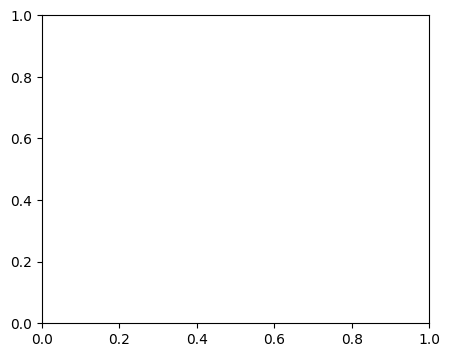

In [167]:
# Animar el tablero

animate_board(board_states)

In [168]:
# Iteraciones
ITERATIONS = 100

wins = 0

# Ejecutar la simulación
for i in range(ITERATIONS):

    # Inicializar el grafo
    G = initialize_board(board_config)

    # Inicializar el modelo
    model = BoardModel(G, board_config, num_agents=6)

    # Ejecutar la simulación
    while model.running:
        model.step()

    # Obtener los datos de la simulación
    if model.win:
        wins += 1


No hay puntos de interés disponibles - POIs: [(2, 4), (5, 8), (3, 3)] - POIs en rescate: [(2, 4), (3, 3), (5, 8)]
No hay puntos de interés disponibles - POIs: [(2, 4), (5, 8), (3, 3)] - POIs en rescate: [(2, 4), (3, 3), (5, 8)]
No hay puntos de interés disponibles - POIs: [(2, 4), (5, 8), (3, 3)] - POIs en rescate: [(2, 4), (3, 3), (5, 8)]
No hay puntos de interés disponibles - POIs: [(2, 4), (5, 8), (6, 7)] - POIs en rescate: [(2, 4), (6, 7), (5, 8)]
No hay puntos de interés disponibles - POIs: [(2, 4), (5, 8), (6, 7)] - POIs en rescate: [(2, 4), (6, 7), (5, 8)]
No hay puntos de interés disponibles - POIs: [(2, 4), (5, 8), (6, 7)] - POIs en rescate: [(2, 4), (6, 7), (5, 8)]
No hay puntos de interés disponibles - POIs: [(2, 4), (5, 8), (1, 2)] - POIs en rescate: [(1, 2), (2, 4), (5, 8)]
No hay puntos de interés disponibles - POIs: [(2, 4), (5, 8), (1, 2)] - POIs en rescate: [(1, 2), (2, 4), (5, 8)]
No hay puntos de interés disponibles - POIs: [(2, 4), (5, 8), (1, 2)] - POIs en rescate:

In [169]:
print(f"Victorias: {wins / ITERATIONS * 100}%")

Victorias: 16.0%
